# 线性回归

In [3]:
%matplotlib inline
import torch
import random

### 数据构造

In [6]:
# 构造一个人造数据集
def synthetic_data(w, b, example_num):
    """生成 y=Xw+b 噪声"""
    X = torch.normal(0, 1, (example_num, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1)) # -1自动计算，1代表列向量

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

`torch.normal(mean, std, size)`
- 从正态分布中生成随机数
- `mean`：正态分布的均值
- `std`：正态分布的标准差
- `size`：输出张量的形状，tuple（比如三行四列）或者int

In [8]:
print('features[0]:', features[0], '\nlabels[0]:', labels[0])

features[0]: tensor([ 0.1731, -0.8516]) 
labels[0]: tensor([7.4410])


/tmp/ipykernel_10551/2819009045.py:27: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) SimHei.
  plt.tight_layout()
/tmp/ipykernel_10551/2819009045.py:27: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
/home/uiyu/anaconda3/envs/pytorch/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)
/home/uiyu/anaconda3/envs/pytorch/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


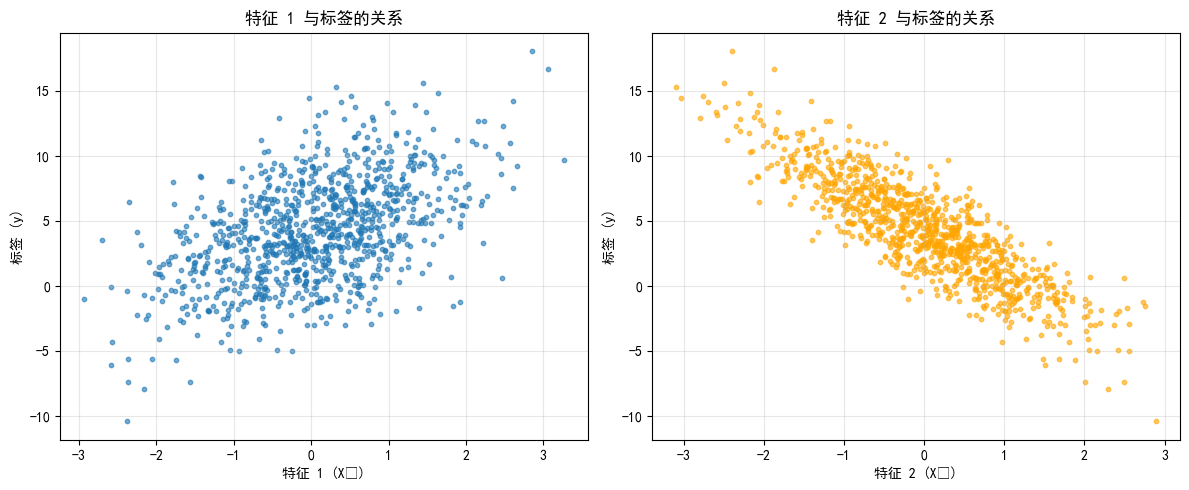

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 设置中文字体和图形样式
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 创建图形
plt.figure(figsize=(12, 5))

# 子图1：特征1 vs 标签
plt.subplot(1, 2, 1)
plt.scatter(features[:, 0].numpy(), labels.numpy(), alpha=0.6, s=10)
plt.xlabel('特征 1 (X₁)')
plt.ylabel('标签 (y)')
plt.title('特征 1 与标签的关系')
plt.grid(True, alpha=0.3)

# 子图2：特征2 vs 标签
plt.subplot(1, 2, 2)
plt.scatter(features[:, 1].numpy(), labels.numpy(), alpha=0.6, s=10, color='orange')
plt.xlabel('特征 2 (X₂)')
plt.ylabel('标签 (y)')
plt.title('特征 2 与标签的关系')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 小批量取样

In [12]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 随机顺序
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i : min(i + batch_size, num_examples)]
        )
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print('X:', X, '\ny', y)
    break

X: tensor([[-2.1663,  0.1576],
        [-0.7002, -0.2651],
        [ 1.0201,  0.2188],
        [-1.4589,  0.3716],
        [ 0.0271,  0.4499],
        [-0.4008, -0.5040],
        [-0.1942,  0.3229],
        [ 0.7267, -1.4656],
        [ 0.8039, -0.0918],
        [ 0.7467,  0.8871]]) 
y tensor([[-0.6647],
        [ 3.6984],
        [ 5.4943],
        [ 0.0313],
        [ 2.7209],
        [ 5.1017],
        [ 2.7153],
        [10.6372],
        [ 6.1140],
        [ 2.6714]])


### 定义初始化模型参数

In [13]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad = True)

### 定义模型

In [19]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

### 定义损失函数

In [20]:
def square_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 定义优化算法

In [21]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size # 求导数不影响乘除法
            param.grad.zero_()

### 训练过程

In [22]:
lr = 0.03
num_epoch = 3
net = linreg
loss = square_loss

for epoch in range(num_epoch):
    for X,y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch:{epoch + 1}, train loss:{float(train_l.mean()):f}')

epoch:1, train loss:0.035864
epoch:2, train loss:0.000126
epoch:3, train loss:0.000053


In [23]:
print(f'w 的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b 的估计误差: {true_b - b}')

w 的估计误差：tensor([ 6.2108e-05, -6.7329e-04], grad_fn=<SubBackward0>)
b 的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)


# 线性回归简洁实现

In [3]:
import torch
from torch.utils import data 

# 构造一个人造数据集
def synthetic_data(w, b, example_num):
    """生成 y=Xw+b 噪声"""
    X = torch.normal(0, 1, (example_num, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1)) # -1自动计算，1代表列向量

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

def load_array(load_arrays, batch_size, is_train=True):
    """构造一个Pytorch数据迭代器"""
    dataset = data.TensorDataset(*load_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))


[tensor([[-1.6855, -1.9982],
         [-1.1205, -0.3794],
         [-0.5740, -0.2142],
         [ 1.0700, -1.8929],
         [ 0.2779,  0.8906],
         [ 0.5897,  0.1704],
         [-0.1691,  0.1177],
         [-0.3010, -2.0448],
         [ 0.4401,  0.8912],
         [-0.3230, -1.5988]]),
 tensor([[ 7.6170],
         [ 3.2528],
         [ 3.7746],
         [12.7743],
         [ 1.7251],
         [ 4.8069],
         [ 3.4651],
         [10.5543],
         [ 2.0580],
         [ 8.9995]])]